In [1]:
# # Code to convert this notebook to .py if you want to run it via command line or with Slurm
# from subprocess import call
# command = "jupyter nbconvert Reconstruction_Metrics.ipynb --to python"
# call(command,shell=True)

In [38]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.utils import make_grid
from tqdm import tqdm
from datetime import datetime
import argparse

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
local_rank = 0
print("device:",device)

import utils
seed=42
utils.seed_everything(seed=seed)

if utils.is_interactive():
    %load_ext autoreload
    %autoreload 2

# from models import Clipper
# clip_extractor = Clipper("ViT-L/14", hidden_state=False, norm_embs=True, device=device)
imsize = 512

device: cuda
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import os
from PIL import Image
import torch
import numpy as np

# Define the source and target directories
source_dir = '/home/ldy/Workspace/Generation/generated_imgs/sub-08'
target_dir = '/home/ldy/Workspace/Generation/generated_imgs_tensor'

# Create the target directory if it doesn't exist
if not os.path.exists(target_dir):
    os.makedirs(target_dir)

# Initialize a list to hold all the image tensors
tensor_list = []
# Initialize a dictionary to map image file names to their categories
image_categories = {}

# Initialize the set to store unique category names
category_set = set()

# Iterate over the folders in the source directory
for folder_name in sorted(os.listdir(source_dir)):
    folder_path = os.path.join(source_dir, folder_name)

    # Extract the category name from the folder name (assuming category is part of folder_name)
    category_name = folder_name.split('_')[-1]  # This splits the folder_name and takes the last part as the category
    category_set.add(category_name)  # Add the category name to the set

    # Check if it's a directory
    if os.path.isdir(folder_path):
        # Sort the image files to ensure consistent order
        image_files = sorted(os.listdir(folder_path))
        # Iterate over the sorted images in the folder
        for image_name in image_files:
            image_path = os.path.join(folder_path, image_name)

            # Map the image name to its category
            image_categories[image_name] = category_name

            # Load the image
            with Image.open(image_path) as img:
                # Convert the image to a PyTorch tensor and add a batch dimension
                tensor = torch.tensor(np.array(img)).unsqueeze(0)
                tensor_list.append(tensor)

# Concatenate all tensors along the 0th dimension
all_tensors = torch.cat(tensor_list, dim=0)

# Save the combined tensor
combined_tensor_path = os.path.join(target_dir, "all_images.pt")
torch.save(all_tensors, combined_tensor_path)

# Now we sort the category names and write them to a file
# along with their associated image names
categories_path = os.path.join(target_dir, "categories.txt")
with open(categories_path, 'w') as f:
    for image_name, category_name in sorted(image_categories.items()):
        f.write(f"{image_name}: {category_name}\n")

# Print out the category list, now sorted
category_list = sorted(list(category_set))
print(category_list)

['antelope', 'backscratcher', 'bag', 'banana', 'basil', 'basket', 'basketball', 'bassoon', 'bat', 'baton4', 'batter', 'beam', 'bean', 'beaver', 'bench', 'bike', 'bleu', 'blowtorch', 'boat', 'bonnet', 'box', 'brace', 'bread', 'breadbox', 'brulee', 'bug', 'buggy', 'bullet', 'bun', 'bush', 'cake', 'calamari', 'candlestick', 'carrier', 'cart', 'cashew', 'cat', 'caterpillar', 'chain', 'chaps', 'cheese', 'cheetah', 'chest2', 'chime', 'chopsticks', 'choy', 'cleat', 'cleaver', 'coat', 'cobra', 'coconut', 'coffeemaker', 'cookie', 'coverall', 'crab', 'crepe', 'crib', 'croissant', 'crow', 'crumb', 'cube', 'cupcake', 'dagger', 'dalmatian', 'dessert', 'detector', 'dragonfly', 'dreidel', 'drum', 'eagle', 'eel', 'egg', 'elephant', 'espresso', 'ferry', 'flamingo', 'folder', 'fork', 'freezer', 'fruit', 'garlic', 'glove', 'gondola', 'goose', 'gopher', 'gorilla', 'grasshopper', 'grenade', 'hamburger', 'hammer', 'handbrake', 'hat', 'headscarf', 'highchair', 'hoodie', 'horn', 'hummingbird', 'jeep', 'jukebo

In [4]:
import os
from PIL import Image
import torch
import numpy as np

# Define the source and target directories
source_dir = '/home/ldy/Workspace/THINGS/images_set/test_images'
target_dir = '/home/ldy/Workspace/THINGS/images_set/test_images_tensor'
# Create the target directory if it doesn't exist
if not os.path.exists(target_dir):
    os.makedirs(target_dir)

# Initialize a list to hold all the image tensors
tensor_list = []
# Initialize a dictionary to map image file names to their categories
image_categories = {}

# Initialize the set to store unique category names
category_set = set()

# Iterate over the folders in the source directory
for folder_name in sorted(os.listdir(source_dir)):
    folder_path = os.path.join(source_dir, folder_name)

    # Extract the category name from the folder name (assuming category is part of folder_name)
    category_name = folder_name.split('_')[-1]  # This splits the folder_name and takes the last part as the category
    category_set.add(category_name)  # Add the category name to the set

    # Check if it's a directory
    if os.path.isdir(folder_path):
        # Sort the image files to ensure consistent order
        image_files = sorted(os.listdir(folder_path))
        # Iterate over the sorted images in the folder
        for image_name in image_files:
            image_path = os.path.join(folder_path, image_name)

            # Map the image name to its category
            image_categories[image_name] = category_name

            # Load the image
            with Image.open(image_path) as img:
                # Convert the image to a PyTorch tensor and add a batch dimension
                tensor = torch.tensor(np.array(img)).unsqueeze(0)
                tensor_list.append(tensor)

# Concatenate all tensors along the 0th dimension
all_tensors = torch.cat(tensor_list, dim=0)

# Save the combined tensor
combined_tensor_path = os.path.join(target_dir, "all_images.pt")
torch.save(all_tensors, combined_tensor_path)

# Now we sort the category names and write them to a file
# along with their associated image names
categories_path = os.path.join(target_dir, "categories.txt")
with open(categories_path, 'w') as f:
    for image_name, category_name in sorted(image_categories.items()):
        f.write(f"{image_name}: {category_name}\n")

# Print out the category list, now sorted
category_list = sorted(list(category_set))
print(category_list)

['antelope', 'backscratcher', 'bag', 'banana', 'basil', 'basket', 'basketball', 'bassoon', 'bat', 'baton4', 'batter', 'beam', 'bean', 'beaver', 'bench', 'bike', 'bleu', 'blowtorch', 'boat', 'bonnet', 'box', 'brace', 'bread', 'breadbox', 'brulee', 'bug', 'buggy', 'bullet', 'bun', 'bush', 'cake', 'calamari', 'candlestick', 'carrier', 'cart', 'cashew', 'cat', 'caterpillar', 'chain', 'chaps', 'cheese', 'cheetah', 'chest2', 'chime', 'chopsticks', 'choy', 'cleat', 'cleaver', 'coat', 'cobra', 'coconut', 'coffeemaker', 'cookie', 'coverall', 'crab', 'crepe', 'crib', 'croissant', 'crow', 'crumb', 'cube', 'cupcake', 'dagger', 'dalmatian', 'dessert', 'detector', 'dragonfly', 'dreidel', 'drum', 'eagle', 'eel', 'egg', 'elephant', 'espresso', 'ferry', 'flamingo', 'folder', 'fork', 'freezer', 'fruit', 'garlic', 'glove', 'gondola', 'goose', 'gopher', 'gorilla', 'grasshopper', 'grenade', 'hamburger', 'hammer', 'handbrake', 'hat', 'headscarf', 'highchair', 'hoodie', 'horn', 'hummingbird', 'jeep', 'jukebo

# Configurations

In [5]:
# # if running this interactively, can specify jupyter_args here for argparser to use
# if utils.is_interactive():
#     # Example use
#     jupyter_args = "--recon_path=prior_257_final_subj01_bimixco_softclip_byol_brain_recons_full_img2img0.85_16samples.pt"
    
#     jupyter_args = jupyter_args.split()
#     print(jupyter_args)

In [6]:
# parser = argparse.ArgumentParser(description="Model Training Configuration")
# parser.add_argument(
#     "--recon_path", type=str,
#     help="path to reconstructed/retrieved outputs",
# )
# parser.add_argument(
#     "--all_images_path", type=str, default="all_images.pt",
#     help="path to ground truth outputs",
# )

# if utils.is_interactive():
#     args = parser.parse_args(jupyter_args)
# else:
#     args = parser.parse_args()

# # create global variables without the args prefix
# for attribute_name in vars(args).keys():
#     globals()[attribute_name] = getattr(args, attribute_name)

In [126]:
recon_path = '/home/ldy/Workspace/Generation/generated_imgs_tensor/all_images.pt'
all_images_path = '/home/ldy/Workspace/THINGS/images_set/test_images_tensor/all_images.pt'
all_brain_recons = torch.load(f'{recon_path}')
all_images = torch.load(f'{all_images_path}')
all_brain_recons = all_brain_recons[::10]


all_images = all_images.to(device)

all_images = all_images.transpose(1, 3)
all_images = all_images.transpose(2, 3)
all_brain_recons = all_brain_recons.transpose(1, 3)
all_brain_recons = all_brain_recons.transpose(2, 3)
print(all_images.shape)
print(all_brain_recons.shape)

all_images = all_images.to(device)
all_brain_recons = all_brain_recons.to(device)


torch.Size([200, 3, 500, 500])
torch.Size([200, 3, 512, 512])


In [130]:
print("Minimum:", all_brain_recons.min().item())
print("Maximum:", all_brain_recons.max().item())
print("Mean:", all_brain_recons.to(dtype=torch.float32).mean().item())

Minimum: 0
Maximum: 255
Mean: 122.06995391845703


In [118]:
# print(all_images)

tensor([[[202, 202, 204,  ..., 212, 211, 212],
         [202, 203, 204,  ..., 212, 212, 214],
         [202, 203, 204,  ..., 212, 214, 214],
         ...,
         [136, 136, 136,  ..., 174, 170, 158],
         [130, 134, 136,  ..., 146, 140, 139],
         [105, 116, 127,  ..., 117, 119, 137]],

        [[203, 204, 206,  ..., 213, 213, 212],
         [204, 204, 206,  ..., 213, 214, 213],
         [204, 204, 206,  ..., 213, 215, 214],
         ...,
         [142, 141, 141,  ..., 177, 172, 160],
         [138, 139, 140,  ..., 150, 143, 141],
         [108, 119, 132,  ..., 124, 122, 138]],

        [[229, 229, 229,  ..., 230, 231, 230],
         [228, 228, 228,  ..., 230, 232, 232],
         [228, 228, 228,  ..., 229, 230, 231],
         ...,
         [148, 148, 148,  ..., 189, 181, 167],
         [144, 147, 146,  ..., 158, 148, 144],
         [114, 126, 138,  ..., 130, 126, 142]]], device='cuda:0',
       dtype=torch.uint8)
tensor([[[132, 132, 130,  ...,  76,  72,  78],
         [132, 1

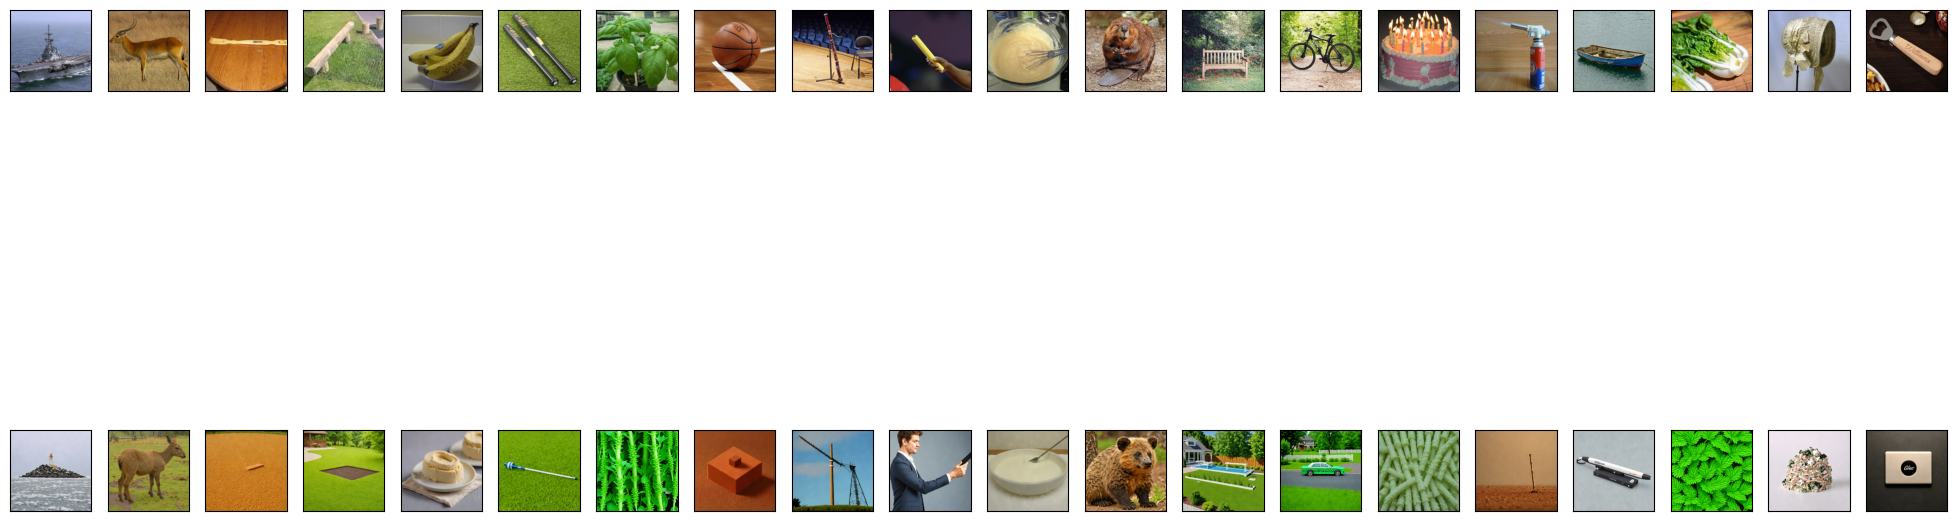

In [138]:

fig, axs = plt.subplots(2, 20, figsize=(25, 10))  # 创建2行5列的子图

# 显示 all_images 中的前5张图像
for i in range(20):
    img = all_images[i].detach()
    img = transforms.ToPILImage()(img/255.0)  # 将张量转换为PIL图像
    axs[0, i].imshow(np.asarray(img))  # 在第一行显示图像
    axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])  # 移除坐标轴标签

# 显示 all_brain_recons 中的前5张图像
for i in range(20):
    img = all_brain_recons[i].detach()
    print(img)
    img = transforms.ToPILImage()(img/255.0)  # 将张量转换为PIL图像
    axs[1, i].imshow(np.asarray(img))  # 在第二行显示图像
    axs[1, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])  # 移除坐标轴标签

plt.show()  # 显示图像


# Display reconstructions next to ground truth images

In [82]:
# all_interleaved = all_interleaved.transpose(1, 3)
all_interleaved.shape
# all_interleaved

torch.Size([20, 3, 256, 256])

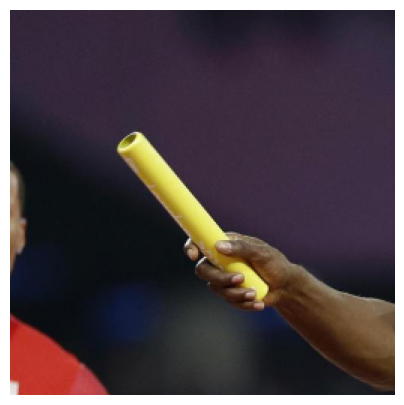

In [134]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np

# Assuming all_interleaved is a tensor with shape [N, C, H, W]
# where N is the number of images, C is the number of channels,
# H is the height, and W is the width of the images.

# Function to show a single image from all_interleaved
def show_single_image(img_tensor, figsize=(5, 5)):
    img_tensor = img_tensor.detach()
    # Convert the tensor to PIL image
    img = transforms.ToPILImage()(img_tensor/255.0)
    # print(img)
    # Plotting
    plt.figure(figsize=figsize)
    plt.imshow(np.asarray(img))
    plt.axis('off')  # Hide the axis
    plt.show()

# Show the first image from all_interleaved
show_single_image(all_interleaved[0, :, :, :])


In [131]:
all_interleaved[0].to(device) - all_images[0]

tensor([[[-140., -140., -140.,  ..., -163., -162., -164.],
         [-138., -138., -138.,  ..., -163., -162., -164.],
         [-137., -137., -137.,  ..., -162., -163., -165.],
         ...,
         [ 142.,  147.,  146.,  ...,  -73.,  -78.,  -78.],
         [ 145.,  154.,  153.,  ...,  -84.,  -82.,  -71.],
         [ 155.,  151.,  156.,  ...,  -71.,  -70.,  -66.]],

        [[-164., -164., -164.,  ..., -175., -174., -176.],
         [-162., -162., -162.,  ..., -175., -174., -176.],
         [-161., -161., -161.,  ..., -174., -175., -177.],
         ...,
         [ 141.,  137.,  126.,  ...,  -99., -103., -103.],
         [ 125.,  137.,  137.,  ...,  -98.,  -94.,  -83.],
         [ 134.,  135.,  139.,  ...,  -85.,  -82.,  -78.]],

        [[-191., -191., -191.,  ..., -206., -205., -207.],
         [-189., -189., -189.,  ..., -206., -205., -207.],
         [-188., -188., -188.,  ..., -205., -206., -208.],
         ...,
         [  91.,   96.,   94.,  ..., -132., -136., -136.],
         [

[9 8 7 6 5 4 3 2 1 0]
all_interleaved tensor([[[ 49.,  49.,  49.,  ...,  34.,  35.,  33.],
         [ 51.,  51.,  51.,  ...,  34.,  35.,  33.],
         [ 52.,  52.,  52.,  ...,  35.,  35.,  33.],
         ...,
         [226., 229., 232.,  ...,  34.,  36.,  40.],
         [235., 231., 231.,  ...,  22.,  19.,  19.],
         [238., 233., 234.,  ...,  22.,  19.,  19.]],

        [[ 36.,  36.,  36.,  ...,  30.,  31.,  29.],
         [ 38.,  38.,  38.,  ...,  30.,  31.,  29.],
         [ 39.,  39.,  39.,  ...,  31.,  31.,  29.],
         ...,
         [236., 230., 223.,  ...,  23.,  25.,  29.],
         [229., 228., 229.,  ...,  23.,  22.,  22.],
         [231., 231., 231.,  ...,  23.,  22.,  22.]],

        [[ 54.,  54.,  54.,  ...,  45.,  46.,  44.],
         [ 56.,  56.,  56.,  ...,  45.,  46.,  44.],
         [ 57.,  57.,  57.,  ...,  46.,  46.,  44.],
         ...,
         [216., 217., 219.,  ...,  19.,  21.,  25.],
         [226., 225., 227.,  ...,  28.,  27.,  27.],
         [228.,

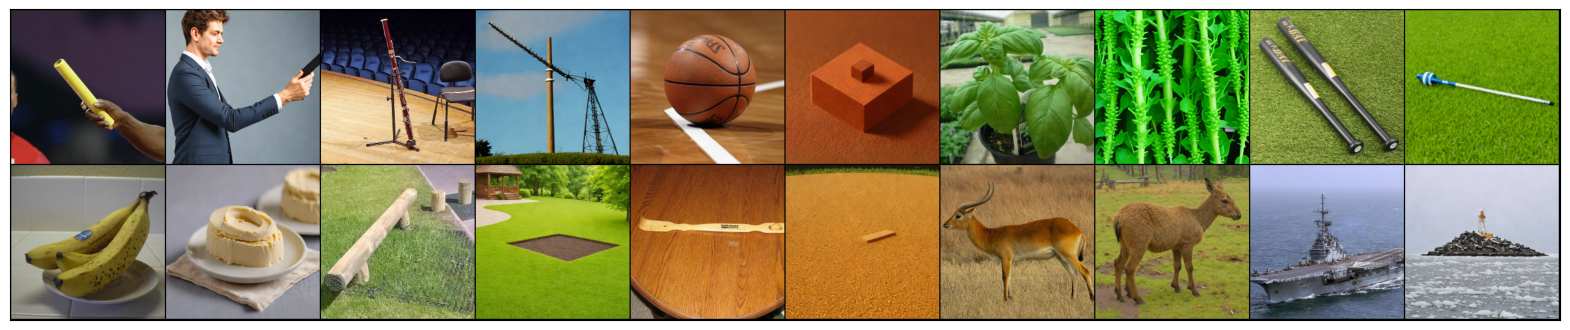

In [133]:
imsize = 256
all_images = transforms.Resize((imsize,imsize))(all_images)
all_brain_recons = transforms.Resize((imsize,imsize))(all_brain_recons)
# np.random.seed(0)
ind = np.flip(np.array([i for i in range(10)]))
print(ind)

all_interleaved = torch.zeros(len(ind)*2,3,imsize,imsize).to(device)

icount = 0
for t in ind:
    all_interleaved[icount] = all_images[t].float().to(device)
    print("all_interleaved", all_interleaved[0])
    all_interleaved[icount+1] = all_brain_recons[t].float().to(device)
    icount += 2



plt.rcParams["savefig.bbox"] = 'tight'
def show(imgs,figsize):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=figsize)
    for i, img in enumerate(imgs):
        print(i)
        img = img.detach()
        img = transforms.ToPILImage()(img/255.0)
        print(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        plt.show()  # 显示图像
grid = make_grid(all_interleaved, nrow=10, padding=2)
# print(grid)
show(grid,figsize=(20,16))

In [ ]:
# import torch
# from torchvision import transforms
# from torchvision.utils import make_grid
# import matplotlib.pyplot as plt
# import numpy as np

# # Assume all_images and all_brain_recons are defined and are lists or datasets of images
# batch_size = 10  # Adjust batch_size depending on your GPU memory
# num_batches = int(np.ceil(len(ind) / batch_size))
# ind = np.flip(np.array([112,119,101,44,159,22,173,174,175,189]))
# for batch_idx in range(num_batches):
#     batch_start = batch_idx * batch_size
#     batch_end = min(batch_start + batch_size, len(ind))
#     batch_indices = ind[batch_start:batch_end]

#     all_interleaved = torch.zeros(len(batch_indices)*2, 3, imsize, imsize)

#     icount = 0
#     for t in batch_indices:
#         img = transforms.Resize((imsize, imsize))(all_images[t])
#         recon = transforms.Resize((imsize, imsize))(all_brain_recons[t])

#         all_interleaved[icount] = img
#         all_interleaved[icount + 1] = recon
#         icount += 2

#     # Show or save the processed images here
#     grid = make_grid(all_interleaved, nrow=10, padding=2)
#     show(grid, figsize=(20, 16))

#     # Optional: Clear cache if you are still facing memory issues
#     if torch.cuda.is_available():
#         torch.cuda.empty_cache()


# 2-Way Identification

In [139]:
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names

@torch.no_grad()
def two_way_identification(all_brain_recons, all_images, model, preprocess, feature_layer=None, return_avg=True):
    preds = model(torch.stack([preprocess(recon) for recon in all_brain_recons], dim=0).to(device))
    reals = model(torch.stack([preprocess(indiv) for indiv in all_images], dim=0).to(device))
    if feature_layer is None:
        preds = preds.float().flatten(1).cpu().numpy()
        reals = reals.float().flatten(1).cpu().numpy()
    else:
        preds = preds[feature_layer].float().flatten(1).cpu().numpy()
        reals = reals[feature_layer].float().flatten(1).cpu().numpy()

    r = np.corrcoef(reals, preds)
    r = r[:len(all_images), len(all_images):]
    congruents = np.diag(r)

    success = r < congruents
    success_cnt = np.sum(success, 0)

    if return_avg:
        perf = np.mean(success_cnt) / (len(all_images)-1)
        return perf
    else:
        return success_cnt, len(all_images)-1

## PixCorr

In [140]:
preprocess = transforms.Compose([
    transforms.Resize((425, 425),interpolation=transforms.InterpolationMode.BILINEAR),
])

# Flatten images while keeping the batch dimension
all_images_flattened = preprocess(all_images).reshape(len(all_images), -1).cpu()
all_brain_recons_flattened = preprocess(all_brain_recons).reshape(len(all_brain_recons), -1).cpu()

print(all_images_flattened.shape)
print(all_brain_recons_flattened.shape)

corrsum = 0
for i in tqdm(range(len(all_images_flattened))):
    corrsum += np.corrcoef(all_images_flattened[i].numpy(), all_brain_recons_flattened[i].numpy())[0][1]
corrmean = corrsum / len(all_images_flattened)

pixcorr = corrmean
print(pixcorr)

torch.Size([200, 541875])
torch.Size([200, 541875])


100%|██████████| 200/200 [00:00<00:00, 343.96it/s]

0.1598757249286259


## SSIM

In [141]:
# see https://github.com/zijin-gu/meshconv-decoding/issues/3
from skimage.color import rgb2gray
from skimage.metrics import structural_similarity as ssim

preprocess = transforms.Compose([
    transforms.Resize(425, interpolation=transforms.InterpolationMode.BILINEAR), 
])

# convert image to grayscale with rgb2grey
img_gray = rgb2gray(preprocess(all_images).permute((0,2,3,1)).cpu())
recon_gray = rgb2gray(preprocess(all_brain_recons).permute((0,2,3,1)).cpu())
print("converted, now calculating ssim...")

ssim_score=[]
for im,rec in tqdm(zip(img_gray,recon_gray),total=len(all_images)):
    ssim_score.append(ssim(rec, im, multichannel=True, gaussian_weights=True, sigma=1.5, use_sample_covariance=False, data_range=1.0))

ssim = np.mean(ssim_score)
print(ssim)

converted, now calculating ssim...


100%|██████████| 200/200 [00:03<00:00, 52.18it/s]

0.3451482618482863


### AlexNet

In [142]:
from torchvision.models import alexnet, AlexNet_Weights
alex_weights = AlexNet_Weights.IMAGENET1K_V1

alex_model = create_feature_extractor(alexnet(weights=alex_weights), return_nodes=['features.4','features.11']).to(device)
alex_model.eval().requires_grad_(False)

# see alex_weights.transforms()
preprocess = transforms.Compose([
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Lambda(lambda x: x.float()/255),    
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])
# Ensure all_images and all_brain_recons are tensors on the correct device and are floating-point
all_images = all_images.to(device).float()  # Ensure conversion to float
all_brain_recons = all_brain_recons.to(device).float()  # Ensure conversion to float

layer = 'early, AlexNet(2)'
print(f"\n---{layer}---")
all_per_correct = two_way_identification(all_brain_recons.to(device).float(), all_images, 
                                                          alex_model, preprocess, 'features.4')
alexnet2 = np.mean(all_per_correct)
print(f"2-way Percent Correct: {alexnet2:.4f}")

layer = 'mid, AlexNet(5)'
print(f"\n---{layer}---")
all_per_correct = two_way_identification(all_brain_recons.to(device).float(), all_images, 
                                                          alex_model, preprocess, 'features.11')
alexnet5 = np.mean(all_per_correct)
print(f"2-way Percent Correct: {alexnet5:.4f}")


---early, AlexNet(2)---
2-way Percent Correct: 0.7756

---mid, AlexNet(5)---
2-way Percent Correct: 0.8659


### InceptionV3

In [143]:
from torchvision.models import inception_v3, Inception_V3_Weights
weights = Inception_V3_Weights.DEFAULT
inception_model = create_feature_extractor(inception_v3(weights=weights), 
                                           return_nodes=['avgpool']).to(device)
inception_model.eval().requires_grad_(False)

# see weights.transforms()
preprocess = transforms.Compose([
    transforms.Resize(342, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Lambda(lambda x: x.float()/255.0),    
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])# Ensure all_images and all_brain_recons are tensors on the correct device and are floating-point
all_images = all_images.to(device).float()  # Ensure conversion to float
all_brain_recons = all_brain_recons.to(device).float()  # Ensure conversion to float

all_per_correct = two_way_identification(all_brain_recons, all_images,
                                        inception_model, preprocess, 'avgpool')
        
inception = np.mean(all_per_correct)
print(f"2-way Percent Correct: {inception:.4f}")

/home/ldy/miniconda3/envs/BCI/lib/python3.10/site-packages/torchvision/models/feature_extraction.py:174: UserWarning: NOTE: The nodes obtained by tracing the model in eval mode are a subsequence of those obtained in train mode. When choosing nodes for feature extraction, you may need to specify output nodes for train and eval mode separately.
  warnings.warn(msg + suggestion_msg)


2-way Percent Correct: 0.7345


### CLIP

In [144]:
import clip
clip_model, preprocess = clip.load("ViT-L/14", device=device)

preprocess = transforms.Compose([
    transforms.Resize(224, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Lambda(lambda x: x.float()/255.0),    
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                         std=[0.26862954, 0.26130258, 0.27577711]),
])
# Ensure all_images and all_brain_recons are tensors on the correct device and are floating-point
all_images = all_images.to(device).float()  # Ensure conversion to float
all_brain_recons = all_brain_recons.to(device).float()  # Ensure conversion to float

all_per_correct = two_way_identification(all_brain_recons, all_images,
                                        clip_model.encode_image, preprocess, None) # final layer
clip_ = np.mean(all_per_correct)
print(f"2-way Percent Correct: {clip_:.4f}")

2-way Percent Correct: 0.7864


### Efficient Net

In [145]:
from torchvision.models import efficientnet_b1, EfficientNet_B1_Weights
weights = EfficientNet_B1_Weights.DEFAULT
eff_model = create_feature_extractor(efficientnet_b1(weights=weights), 
                                    return_nodes=['avgpool']).to(device)
eff_model.eval().requires_grad_(False)

# see weights.transforms()
preprocess = transforms.Compose([
    transforms.Resize(255, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])


# Process all_images
gt = eff_model(torch.stack([preprocess(img.float()) for img in all_images.to(device)], dim=0))['avgpool']
gt = gt.reshape(len(gt),-1).cpu().numpy()

# Process all_brain_recons
fake = eff_model(torch.stack([preprocess(recon.float()) for recon in all_brain_recons.to(device)], dim=0))['avgpool']
fake = fake.reshape(len(fake),-1).cpu().numpy()

effnet = np.array([sp.spatial.distance.correlation(gt[i],fake[i]) for i in range(len(gt))]).mean()
print("Distance:",effnet)


Distance: 0.8261442418802472


### SwAV

In [ ]:
all_images

In [ ]:
all_brain_recons

In [ ]:
# Ensure all_images and all_brain_recons are tensors on the correct device and are floating-point
all_images = all_images.to(device).float()  # Ensure conversion to float
all_brain_recons = all_brain_recons.to(device).float()  # Ensure conversion to float


In [147]:
swav_model = torch.hub.load('facebookresearch/swav:main', 'resnet50')
swav_model = create_feature_extractor(swav_model, 
                                    return_nodes=['avgpool']).to(device)
swav_model.eval().requires_grad_(False)

preprocess = transforms.Compose([
    transforms.Resize(224, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Lambda(lambda x: x.float()/255.0),    
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])
# Ensure all_images and all_brain_recons are tensors on the correct device and are floating-point
all_images = all_images.to(device).float()  # Ensure conversion to float
all_brain_recons = all_brain_recons.to(device).float()  # Ensure conversion to float

gt = swav_model(preprocess(all_images))['avgpool']
gt = gt.reshape(len(gt),-1).cpu().numpy()
fake = swav_model(preprocess(all_brain_recons))['avgpool']
fake = fake.reshape(len(fake),-1).cpu().numpy()

swav = np.array([sp.spatial.distance.correlation(gt[i],fake[i]) for i in range(len(gt))]).mean()
print("Distance:",swav)

Using cache found in /home/ldy/.cache/torch/hub/facebookresearch_swav_main
/home/ldy/miniconda3/envs/BCI/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ldy/miniconda3/envs/BCI/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Distance: 0.581689710393548


# Display in table

In [148]:
# Create a dictionary to store variable names and their corresponding values
data = {
    "Metric": ["PixCorr", "SSIM", "AlexNet(2)", "AlexNet(5)", "InceptionV3", "CLIP", "EffNet-B", "SwAV"],
    "Value": [pixcorr, ssim, alexnet2, alexnet5, inception, clip_, effnet, swav],
}

df = pd.DataFrame(data)
print(df.to_string(index=False))

if not utils.is_interactive():
    # save table to txt file
    df.to_csv(f'{recon_path[:-3]}.csv', sep='\t', index=False)

     Metric    Value
    PixCorr 0.159876
       SSIM 0.345148
 AlexNet(2) 0.775603
 AlexNet(5) 0.865905
InceptionV3 0.734472
       CLIP 0.786407
   EffNet-B 0.826144
       SwAV 0.581690
